In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import beta, binom
import itertools
from ipywidgets import interact, interactive
import statsmodels.api as sm

import sklearn
from sklearn.linear_model import LogisticRegression as LR

In [131]:
#load dataset
birth = pd.read_csv('subsampled_clean_data.csv')
birth

,Unnamed: 0,ATTEND,BFACIL,BMI,DBWT,DMAR,FAGECOMB,FEDUC,FRACE6,LD_INDL,...,PRIORLIVE,PRIORTERM,RDMETH_REC,RESTATUS,RF_CESAR,SEX,PREG_LEN,WTGAIN_PER,CIG,FIRST_BIRTH
0,2780164,1,1,31.4,3670,1,29,6,1,N,...,False,False,1,2,N,M,9,0.000000,False,True
1,1306496,2,1,27.6,3494,1,34,4,1,Y,...,True,False,1,1,N,F,9,0.120482,False,False
2,3027006,1,1,27.1,3374,2,43,2,1,N,...,True,True,1,1,N,M,10,0.061350,True,False
3,903600,1,1,26.8,3520,1,30,3,1,Y,...,False,True,1,1,N,M,9,0.301282,False,True
4,2813944,1,1,21.3,3140,1,30,5,1,N,...,False,False,1,3,N,M,9,0.208333,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1541267,1,1,35.9,3062,1,30,4,1,Y,...,True,False,1,1,N,M,9,0.173684,False,False
9996,1786746,1,1,22.5,3855,1,30,3,1,Y,...,False,False,3,1,N,M,9,0.263514,False,True
9997,1928116,1,1,20.4,2710,1,39,2,1,Y,...,True,True,1,2,N,M,9,0.388889,True,False
9998,60244,1,1,24.4,3118,1,35,2,1,Y,...,False,False,3,2,N,M,10,0.147887,False,True


## Causal Inference - Observational Studies

In [132]:
causal_effect = np.mean(birth[birth["CIG"] == True].DBWT) - np.mean(birth[birth["CIG"] == False].DBWT)
causal_effect

-115.41768336628411

The causal effect of cigarettes on baby's birth weight is negative, meaning that smoking will lead to a lower birth weight.

## Outcome Regression

We know that BMI and prenatal care may be confounders. Then by unconfoundedness, we could fit a linear model of the following form:

$\text{Birth Weights} = \tau * Z + a*\text{BMI}+ b*\text{PRECARE} $

If we make two assumptions, then the estimated coefficient of treament from OLS, $\hat{\tau}$, will be an unbiased estimate of the ATE. The two assumptions are:

1. Assume unconfoundedness given `BMI` and `PRECARE`.
2. Assume this linear model correctly describes the interaction between the variables.

First, in order to fit the regression, we need to change categorical variable `CIG` to dummy variable `CIG_True`.

In [133]:
#change categorical data to dummy variable
birth = pd.get_dummies(birth, columns=['CIG'], drop_first=True)
birth

,Unnamed: 0,ATTEND,BFACIL,BMI,DBWT,DMAR,FAGECOMB,FEDUC,FRACE6,LD_INDL,...,PRIORLIVE,PRIORTERM,RDMETH_REC,RESTATUS,RF_CESAR,SEX,PREG_LEN,WTGAIN_PER,FIRST_BIRTH,CIG_True
0,2780164,1,1,31.4,3670,1,29,6,1,N,...,False,False,1,2,N,M,9,0.000000,True,0
1,1306496,2,1,27.6,3494,1,34,4,1,Y,...,True,False,1,1,N,F,9,0.120482,False,0
2,3027006,1,1,27.1,3374,2,43,2,1,N,...,True,True,1,1,N,M,10,0.061350,False,1
3,903600,1,1,26.8,3520,1,30,3,1,Y,...,False,True,1,1,N,M,9,0.301282,True,0
4,2813944,1,1,21.3,3140,1,30,5,1,N,...,False,False,1,3,N,M,9,0.208333,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1541267,1,1,35.9,3062,1,30,4,1,Y,...,True,False,1,1,N,M,9,0.173684,False,0
9996,1786746,1,1,22.5,3855,1,30,3,1,Y,...,False,False,3,1,N,M,9,0.263514,True,0
9997,1928116,1,1,20.4,2710,1,39,2,1,Y,...,True,True,1,2,N,M,9,0.388889,False,1
9998,60244,1,1,24.4,3118,1,35,2,1,Y,...,False,False,3,2,N,M,10,0.147887,True,0


treatement (Z): `birth['CIG_True']`

outcome (Y): `birth['DBWT']`

confounder (X): `birth['BMI']`, `birth['PRECARE']`

units: baby's birth weights

In [134]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    return np.mean((true_vals - predicted_vals) ** 2)

In [135]:
full_linear_model = fit_OLS_model(birth, 'DBWT', ['CIG_True', 'BMI', 'PRECARE'])
print(full_linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   DBWT   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                          4.611e+04
Date:                Sat, 03 Dec 2022   Prob (F-statistic):                        0.00
Time:                        14:09:44   Log-Likelihood:                         -81848.
No. Observations:               10000   AIC:                                  1.637e+05
Df Residuals:                    9997   BIC:                                  1.637e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0.5, 1.0, "Distributions of Babies' Weights under Different Cigarettes Usage")

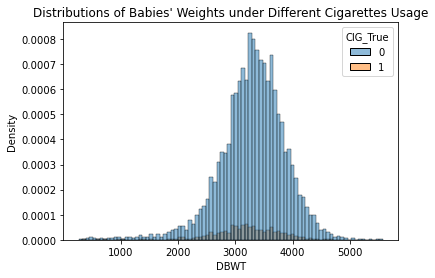

In [136]:
sns.histplot(data=birth, x='DBWT', hue='CIG_True', stat='density')
plt.title("Distributions of Babies' Weights under Different Cigarettes Usage")

In [143]:
birth.groupby('CIG_True')['DBWT'].mean()

CIG_True
0    3299.782786
1    3184.365103
Name: DBWT, dtype: float64

Text(0.5, 1.0, "Distributions of Babies' Weights under Different Prenatal Care Levels")

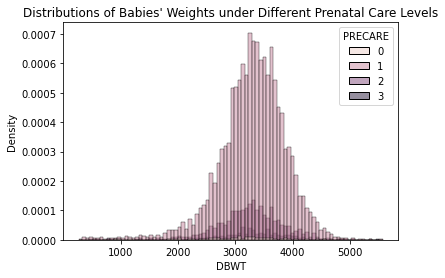

In [137]:
sns.histplot(data=birth, x='DBWT', hue='PRECARE', stat='density')
plt.title("Distributions of Babies' Weights under Different Prenatal Care Levels")

In [144]:
birth.groupby('PRECARE')['DBWT'].mean()

PRECARE
0    3056.591398
1    3301.014548
2    3253.022464
3    3295.043228
Name: DBWT, dtype: float64

From the outcome regression results table, we can see that by using `BMI` and `PRECARE` as confounders, the causal coefficient of cigarettes consumption on babies' weights is around -104.8. This means that smoking an extra cigarette will likely decrease the baby's weight by 104.8 grams. 

From the graphs above, we can also see that the distribution of babies' weights, whether mother smoke or not, are uniformly distributed. However, babies whose mothers don't smoke tend to weigh more than those whose mothers do, having a difference in mean around 115 grams. 

We can see that the distribution of babies' weights with different levels of prenatal care are also uniformly distributed. Generally, more prenatal care will lead to higher babies weights, and level-3 precare has the highest average weight of 3295 grams. However, we can see that the average weights of babies under level-1 precare is actually higher for those under level-2. What causes this difference is unkown.

### Inverse Propensity Score

In this section, we use inverse propensity weighting. 

Propensity score calculates the probability that a unit was treated, conditioned on a particular set of confounders $x$:

$$
e(x) = P(Z=1 | X=x)
$$

For inverse propensity weighting (IPW). Let $n = n_0 + n_1$ be the total number of observations. The IPW estimator of the ATE is:

$$ \hat{\tau}_{IPW} = \frac{1}{n} \sum_{i: Z_i = 1} \frac{Y_i}{e(X_i)} - \frac{1}{n}\sum_{i: Z_i = 0} \frac{Y_i}{1-e(X_i)}$$

In [138]:
Z = birth.CIG_True.values
Y = birth.DBWT.values
X = birth[['BMI', 'PRECARE']]

lr = LR(max_iter=200, random_state=0)
lr.fit(X, Z)

LogisticRegression(max_iter=200, random_state=0)

In [139]:
birth['pscore'] = lr.predict_proba(X)[:,1]
birth

,Unnamed: 0,ATTEND,BFACIL,BMI,DBWT,DMAR,FAGECOMB,FEDUC,FRACE6,LD_INDL,...,PRIORTERM,RDMETH_REC,RESTATUS,RF_CESAR,SEX,PREG_LEN,WTGAIN_PER,FIRST_BIRTH,CIG_True,pscore
0,2780164,1,1,31.4,3670,1,29,6,1,N,...,False,1,2,N,M,9,0.000000,True,0,0.068063
1,1306496,2,1,27.6,3494,1,34,4,1,Y,...,False,1,1,N,F,9,0.120482,False,0,0.063830
2,3027006,1,1,27.1,3374,2,43,2,1,N,...,True,1,1,N,M,10,0.061350,False,1,0.063292
3,903600,1,1,26.8,3520,1,30,3,1,Y,...,True,1,1,N,M,9,0.301282,True,0,0.062971
4,2813944,1,1,21.3,3140,1,30,5,1,N,...,False,1,3,N,M,9,0.208333,True,0,0.057350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1541267,1,1,35.9,3062,1,30,4,1,Y,...,False,1,1,N,M,9,0.173684,False,0,0.073410
9996,1786746,1,1,22.5,3855,1,30,3,1,Y,...,False,3,1,N,M,9,0.263514,True,0,0.058535
9997,1928116,1,1,20.4,2710,1,39,2,1,Y,...,True,1,2,N,M,9,0.388889,False,1,0.076169
9998,60244,1,1,24.4,3118,1,35,2,1,Y,...,False,3,2,N,M,10,0.147887,True,0,0.060458


In [147]:
n = len(birth)
ipw = np.sum(birth[birth["CIG_True"] == 1].DBWT / birth[birth["CIG_True"] == 1].pscore)/n - np.sum(birth[birth["CIG_True"] == 0].DBWT / (1 - birth[birth["CIG_True"] == 0].pscore))/n
ipw

-121.73829642696819

We can see that by applying inverse propensity weighting, the coefficient of cigarettes on babies' birth is around -121.74, meaning that smoking an extra cigarette will likely decrease the baby's weight by 121.74 grams.

Anomalies happens if some observations are rare in the treatment group (i.e.  𝑒(𝑋)≈0 ), which may cause the inverse propensity score,  1/𝑒(𝑋)  to be enormous. Therefore, we decide to only include points with propensity scores between 0.1 and 0.9 which accepts some bias to reduce the variance.

In [148]:
birth_new = birth[(birth['pscore'] > 0.1) & (birth['pscore'] < 0.9)]
n = len(birth_new)
trimmed_ipw = np.sum(birth_new[birth_new["CIG_True"] == 1].DBWT / birth_new[birth_new["CIG_True"] == 1].pscore)/n - np.sum(birth_new[birth_new["CIG_True"] == 0].DBWT / (1 - birth_new[birth_new["CIG_True"] == 0].pscore))/n
trimmed_ipw

-593.0929729236886

Now, we can see that the coefficient of cigarettes on babies' birth becomes larger, around -593, meaning that smoking an extra cigarette will likely decrease the baby's weight by 593 grams.